In [1]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
import random

from utils.data_loaders import get_wake_datasets
from utils.evaluation import evaluate_model
import utils.plotting as plotting

In [6]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
#INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4, 'x/D': 4, 'y/D': 4}
#train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()]).replace("/", "")
INPUT_VAR_TO_TRAIN_RANGES = {'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
train_range_string = "training_ranges=" + '-'.join([f"{var}{r[0]}-{r[1]}" for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items() for r in ranges])
EXPERIMENT = "extrapolation"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
MAX_DEPTH = 20

MODEL_NAME = f"univariate_DT_max-depth{MAX_DEPTH}_{train_range_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
MODEL_DESCRIPTION=MODEL_NAME+"_"+FACTORS_FOLDER
print(MODEL_DESCRIPTION)

univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01


In [ ]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(DATA_FOLDER,
                                                               consider_ws=CONSIDER_WS,
                                                               coords_as_input=COORDS_AS_INPUT,
                                                               #train_perc=0.6,
                                                               #validation_perc=0.2,
                                                               #test_perc=0.2
                                                               #input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                               input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
                                                               )

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

#grid_size = train_dataset.num_cells
#print(f"{grid_size=}")

In [ ]:
train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)
train_size = train_x.shape[0]

test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_size = test_x.shape[0]

valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
print("Valid shapes: ", valid_x.shape, valid_y.shape)
valid_size = valid_x.shape[0]

size = train_size + test_size + valid_size
print(train_size/size, test_size/size, valid_size/size)

Train shapes:  torch.Size([7347200, 4]) torch.Size([7347200, 1])
Test shapes:  torch.Size([27145216, 4]) torch.Size([27145216, 1])
Valid shapes:  torch.Size([27152384, 4]) torch.Size([27152384, 1])
0.11918604651162791 0.44034883720930235 0.44046511627906976


# Training

In [ ]:
model = DecisionTreeRegressor(max_depth=MAX_DEPTH)
model.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=20)

In [ ]:
print("Number of nodes: ", model.tree_.node_count)
print("Depth: ", model.get_depth())

Number of nodes:  1887495
Depth:  20


In [ ]:
feature_names = [train_dataset.featurenum_to_featurename(i) for i in range(4)]
tree_text = export_text(model, feature_names=feature_names)
print(tree_text)

In [8]:
importances = model.feature_importances_
for featurenum, importance in enumerate(importances):
    featurename = train_dataset.featurenum_to_featurename(featurenum)
    print(f"{featurename} feature importance={importance}")

ti feature importance=0.04790983510141311
ct feature importance=0.07985286259638953
x/D feature importance=0.24139941426057668
y/D feature importance=0.6308378880416207


# Evaluation and testing

In [11]:
save_results = False

# evaluation on trainset
evaluate_model(model, data=(train_x, train_y), data_type='train',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results, experiment=EXPERIMENT)

print("\n")

# evalution on testset
evaluate_model(model, data=(test_x, test_y), data_type='test',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results, experiment=EXPERIMENT)

Train results for univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
metrics/final_results/trainset_results_extrapolation.csv
r2_score=0.9989088572616853
explained_variance_score=0.998908858039795
mean_squared_error=9.91506781832501e-07
mean_absolute_error=0.0003730499283716571
median_absolute_error=0.00010729905417455107
mean_absolute_percentage_error=0.019914325680720903
peak_signal_noise_ratio=60.03704310906627
Prediction time=1.250439443550874e-07s


Test results for univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
metrics/final_results/testset_results_extrapolation.csv
r2_score=0.7993126078686946
explained_variance_score=0.7995064181889949
mean_squared_error=0.00023089642250509427
mean_absolute_error=0.006430153534557039
median_absolute_error=0.00260445439036832
mean_absolute_percentage_error=1229367095414.4207
peak_signal_noise_ratio=36.365

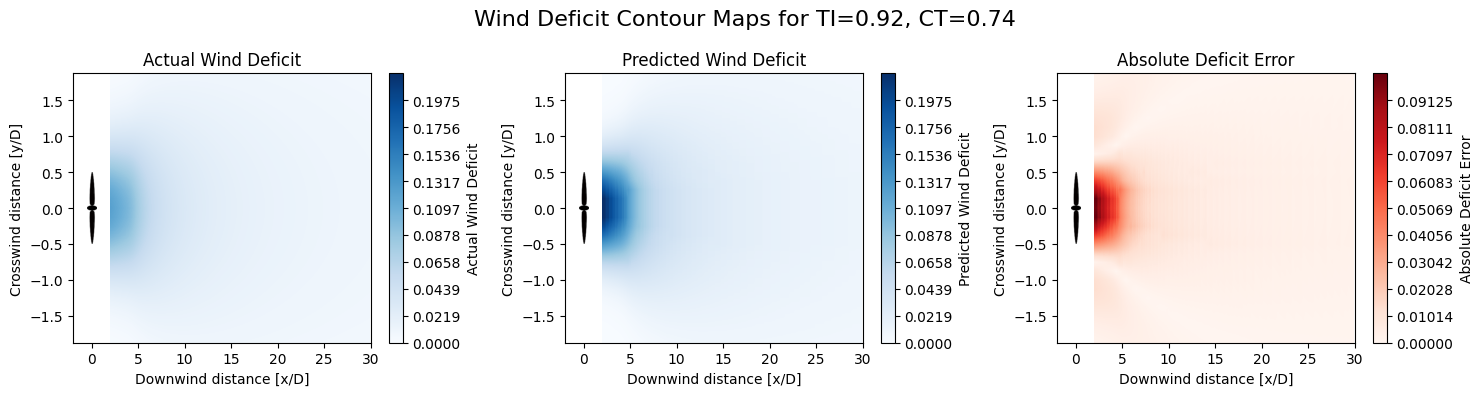

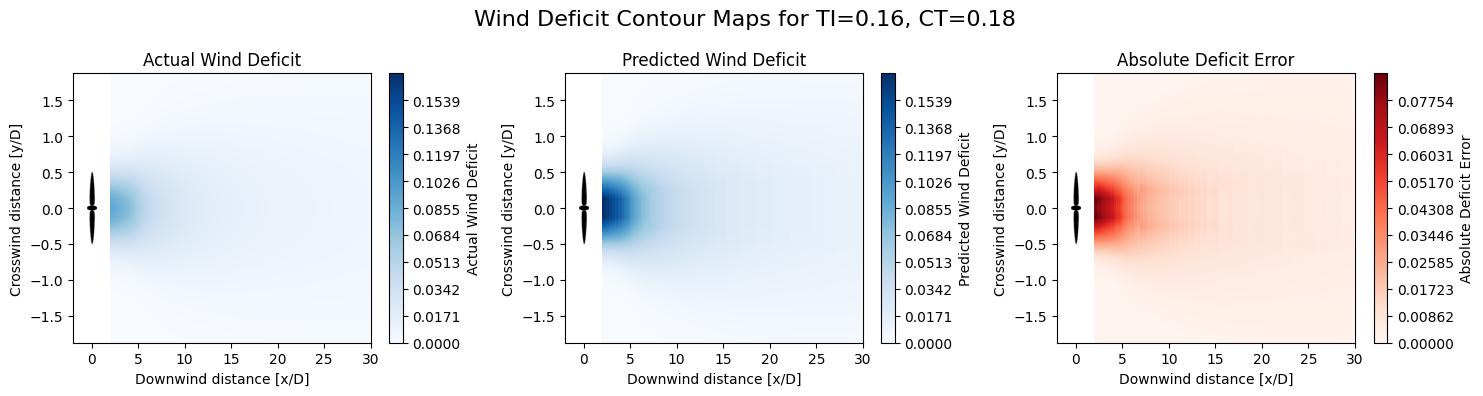

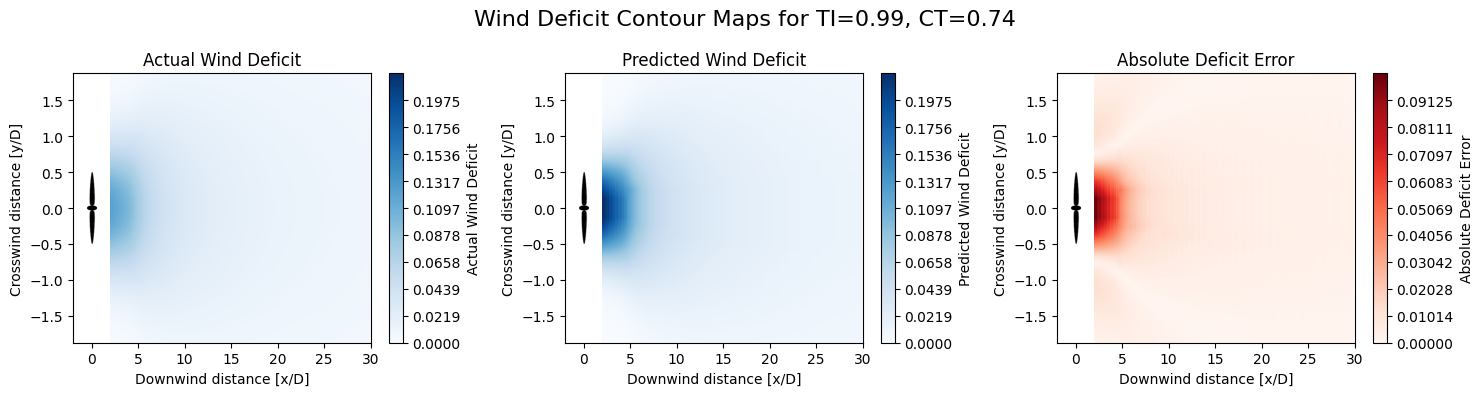

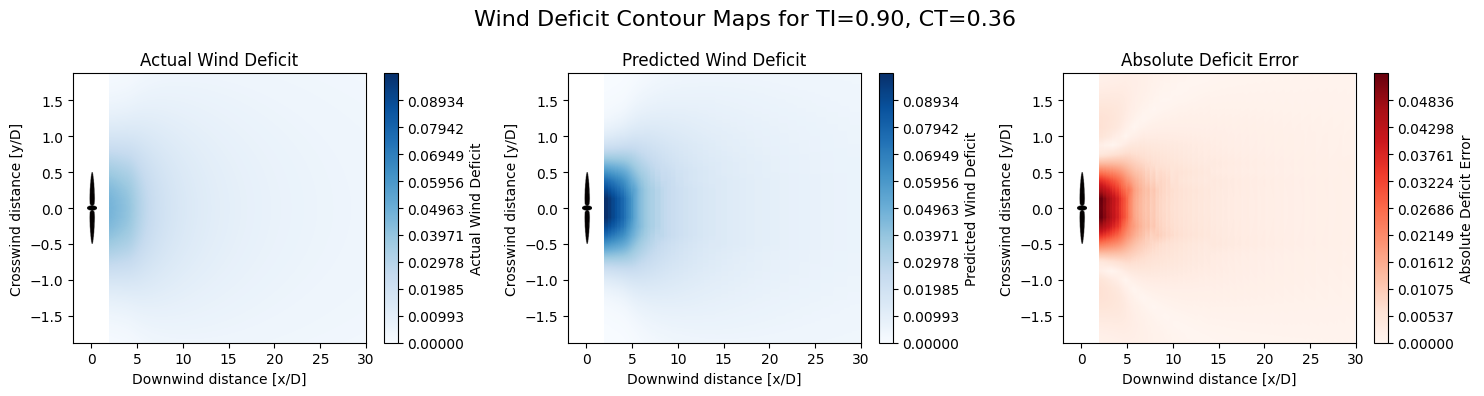

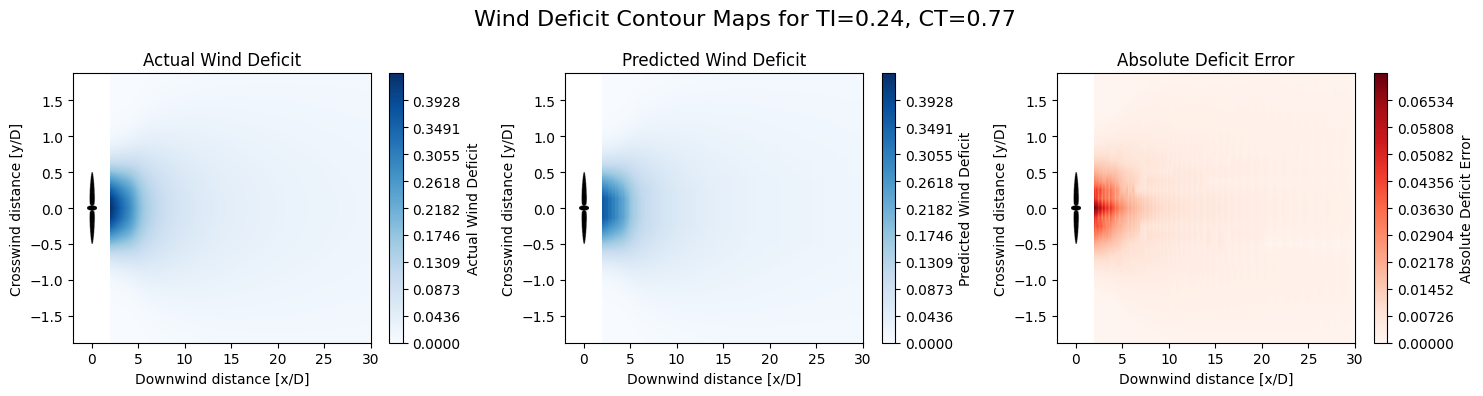

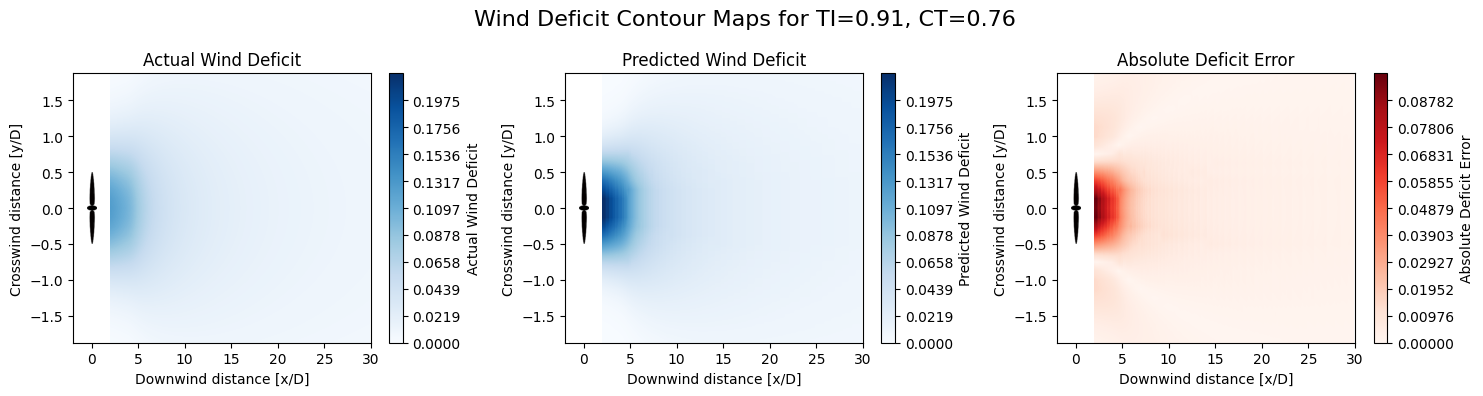

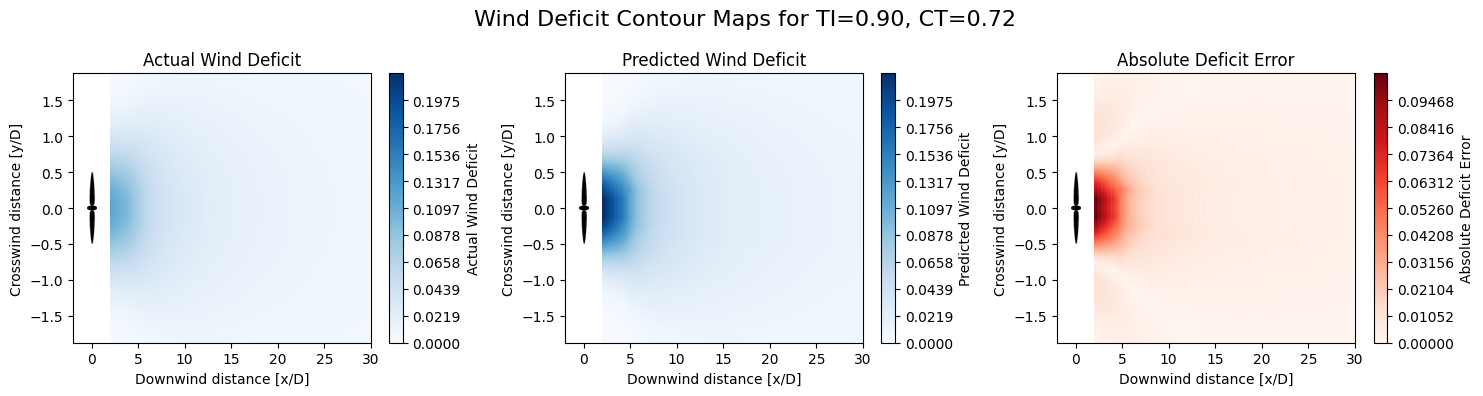

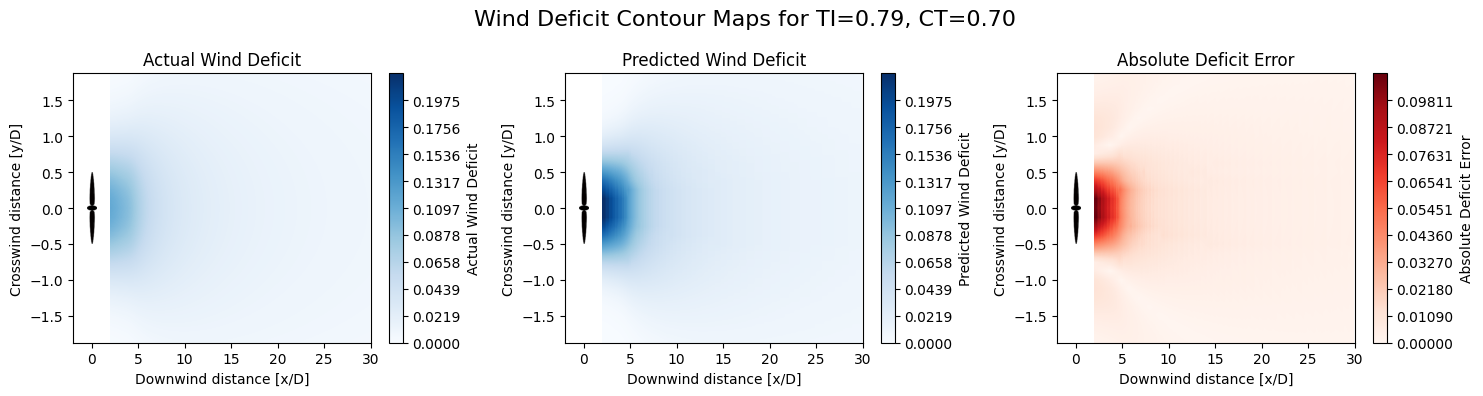

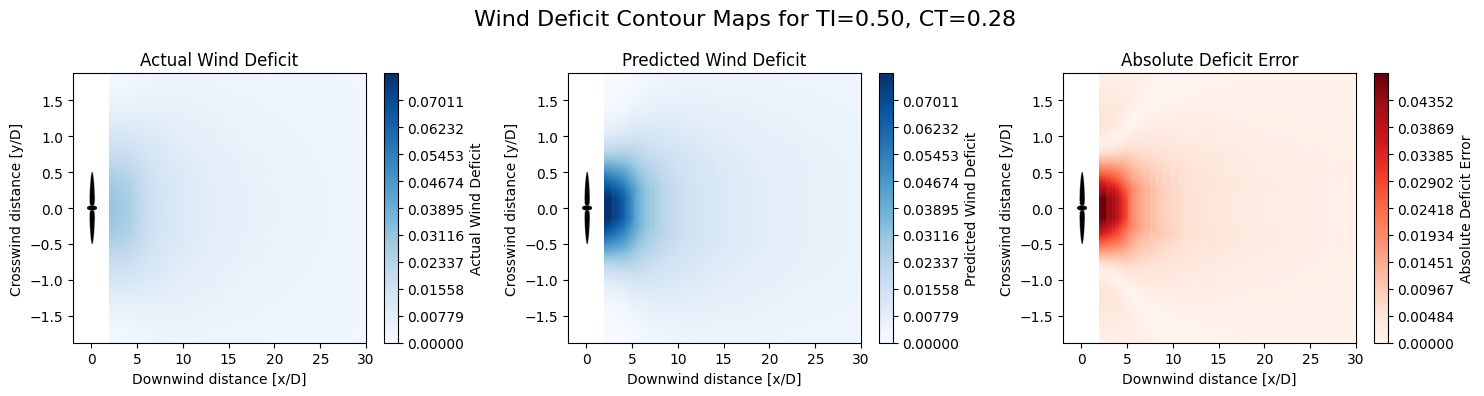

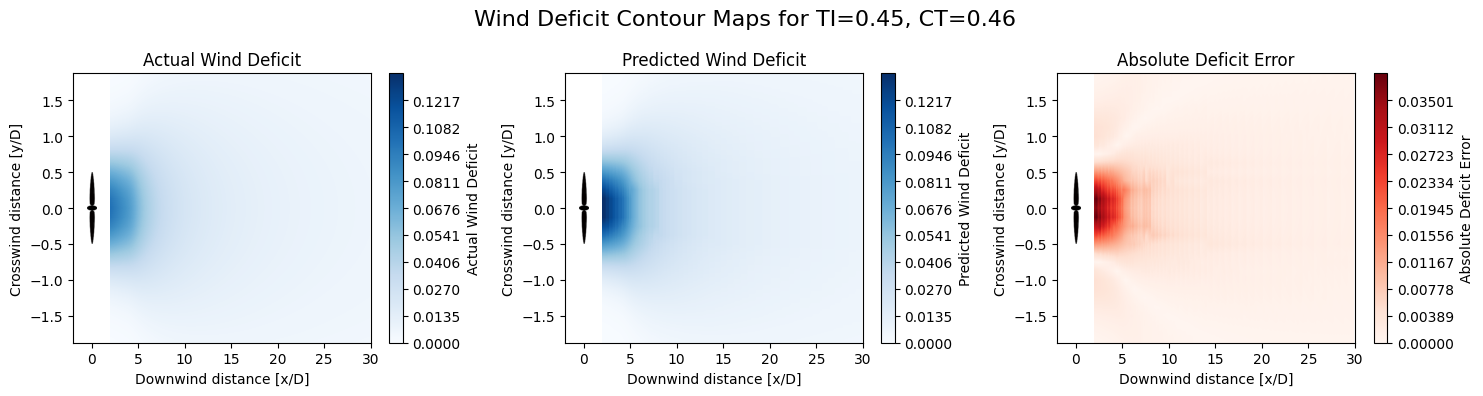

In [10]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
#random.shuffle(field_indices)

for field_idx in field_indices[500:510]:
    ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
    plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')